In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

rows = cols = 28

(x_train , y_train) , (x_test, y_test) = mnist.load_data()
x_train = np.array(x_train, dtype=np.float64)/ 127.5 -1

x_train = np.expand_dims(x_train, axis=3)


2024-11-16 20:22:59.868020: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 20:22:59.869406: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 20:22:59.890789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 20:22:59.890811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 20:22:59.891378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
generator = tf.keras.Sequential([   
    layers.Dense(256, input_dim=100),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(512),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(1024),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(28*28, activation = "tanh"),
    layers.Reshape((28, 28, 1))
])  

discriminator = tf.keras.Sequential([
    layers.Flatten(input_shape = (28,28,1)),
    layers.Dense(1024),
    layers.LeakyReLU(),
    layers.Dense(512),
    layers.LeakyReLU(),
    layers.Dense(256),
    layers.LeakyReLU(),
    layers.Dense(1,activation = 'sigmoid')
])

gan  = keras.Sequential()
gan.add(generator)
gan.add(discriminator)


2024-11-16 20:23:01.175994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-16 20:23:01.176275: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

In [4]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)              

In [5]:
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

In [ ]:
g_acur_arr = np.zeros((400))
g_loss_arr = np.zeros((400))
d_loss_arr = np.zeros((400))
d_acur_arr = np.zeros((400))

batch_size = 64
file = open("out.txt", "w")
for epoch in range(30000):
    
    noise = np.random.normal(0, 1, (batch_size, 100))

    gen_im = generator.predict(noise)
    real_im = x_train[np.random.randint(0, x_train.shape[0], batch_size)]

    loss_fake = discriminator.train_on_batch(gen_im, np.zeros(batch_size))
    loss_real = discriminator.train_on_batch(real_im, np.ones(batch_size))
    
    d_loss = 0.5 * np.add(loss_fake, loss_real)
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones(batch_size))
    
    if epoch % 100 == 0:
        file.write(f"Эпоха {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss[0]} \n")
        g_acur_arr[epoch//100] = g_loss[1]
        g_loss_arr[epoch//100] = g_loss[0]
        d_loss_arr[epoch//100] = d_loss[0]
        d_acur_arr[epoch//100] = d_loss[1]
        file.flush()
    if epoch % 1000 == 0:
        samples = generator.predict(np.random.normal(0, 1, (16, 100)))
        samples = (samples + 1) / 2.0
        fig, axs = plt.subplots(4, 4)
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(samples[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f"cgenerated_images_epoch_{epoch}.png")
        plt.close()
        
file.close()


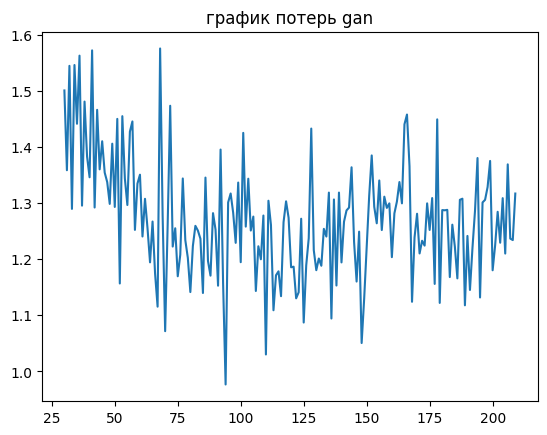

In [ ]:
x_val = np.arange(0,210)

plt.plot(x_val[30:], g_loss_arr[30:210])
plt.title("график потерь gan")
plt.show()

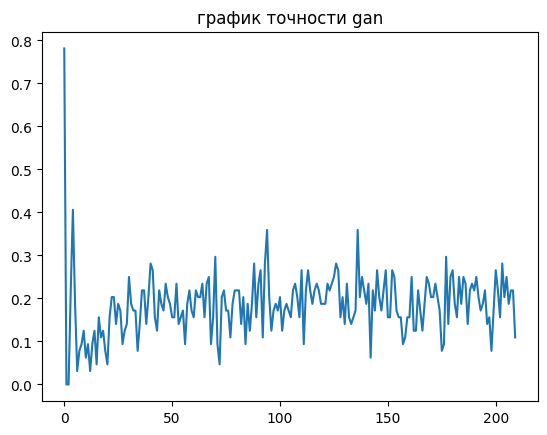

In [ ]:
plt.plot(x_val, g_acur_arr[0:210])
plt.title("график точности gan")
plt.show()

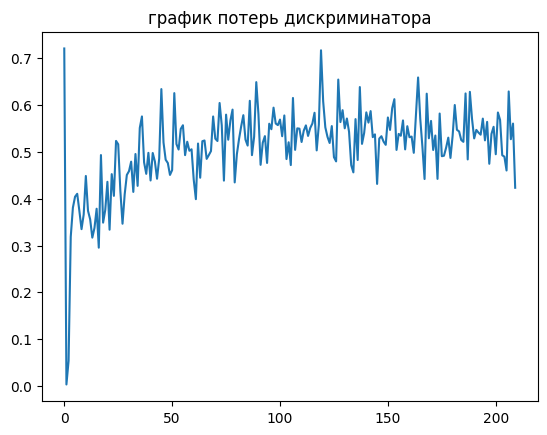

In [ ]:
plt.plot(x_val, d_loss_arr[0:210])
plt.title("график потерь дискриминатора")
plt.show()

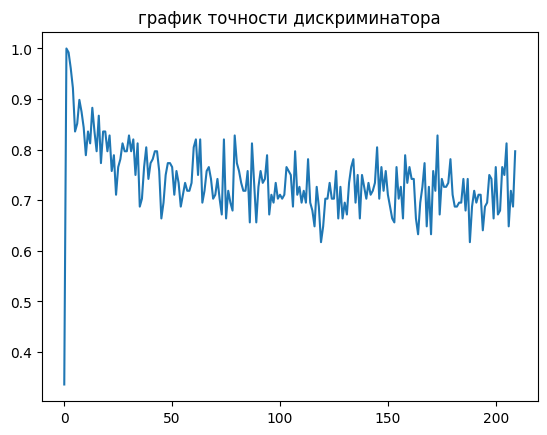

In [ ]:
plt.plot(x_val, d_acur_arr[0:210])
plt.title("график точности дискриминатора")
plt.show()